In [201]:
%load_ext autoreload
%autoreload 2

import sys
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('../src')
from dota import Match
from youtube import (
    analyze_video, crop_frame, extract_text, convert_to_timestamp, get_video_metadata,
    get_nearest_matches, generate_team_pairs, search_team_pairs
)
from utils import plot_player_signals, TimeTable, calculate_iou
from settings import FRAMES_DIR, YOUTUBE_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quick Start

In [88]:
match = Match.from_id(6676393091)
match

Match: 6676393091, parsed: False

In [89]:
match.parse()

In [66]:
match.get_action_moments()

[{'start': -11, 'end': -4, 'clock_start': '-1:49', 'clock_end': '-1:56'},
 {'start': 50, 'end': 75, 'clock_start': '00:50', 'clock_end': '01:15'},
 {'start': 97, 'end': 104, 'clock_start': '01:37', 'clock_end': '01:44'},
 {'start': 130, 'end': 140, 'clock_start': '02:10', 'clock_end': '02:20'},
 {'start': 160, 'end': 188, 'clock_start': '02:40', 'clock_end': '03:08'},
 {'start': 207, 'end': 225, 'clock_start': '03:27', 'clock_end': '03:45'},
 {'start': 240, 'end': 265, 'clock_start': '04:00', 'clock_end': '04:25'},
 {'start': 276, 'end': 288, 'clock_start': '04:36', 'clock_end': '04:48'},
 {'start': 302, 'end': 334, 'clock_start': '05:02', 'clock_end': '05:34'},
 {'start': 377, 'end': 398, 'clock_start': '06:17', 'clock_end': '06:38'},
 {'start': 415, 'end': 421, 'clock_start': '06:55', 'clock_end': '07:01'},
 {'start': 453, 'end': 500, 'clock_start': '07:33', 'clock_end': '08:20'},
 {'start': 514, 'end': 524, 'clock_start': '08:34', 'clock_end': '08:44'},
 {'start': 549, 'end': 556, '

# Details
## Highlights Detector

In [67]:
player = match.players[1]
player

MatchPlayer at match: 6676393091, slot: 1, hero_name: npc_dota_hero_pangolier, steam_id: 76561198134243802

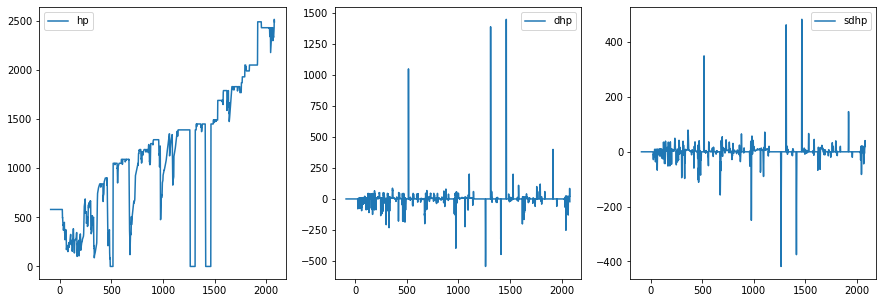

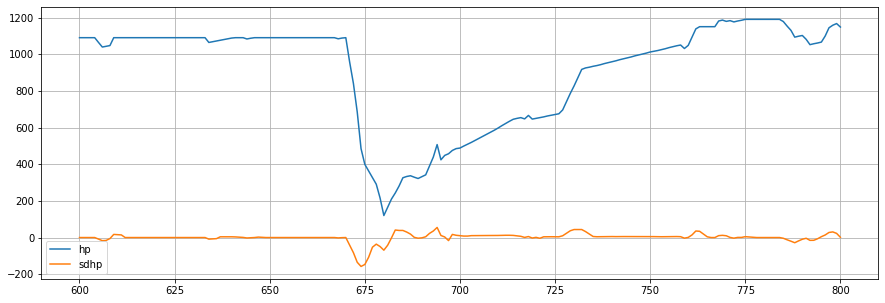

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot_player_signals(
    player,
    ax=ax[0],
    hp=True,
)

plot_player_signals(
    player,
    ax=ax[1],
    dhp=True
)

plot_player_signals(
    player,
    ax=ax[2],
    sdhp=True
)

zoom_start, zoom_end = 600, 800
fig, ax = plt.subplots(figsize=(15, 5))
plot_player_signals(
    player,
    ax=ax,
    zoom_start=zoom_start,
    zoom_end=zoom_end,
    hp=True,
    sdhp=True,
)

plt.grid(True)
plt.show()

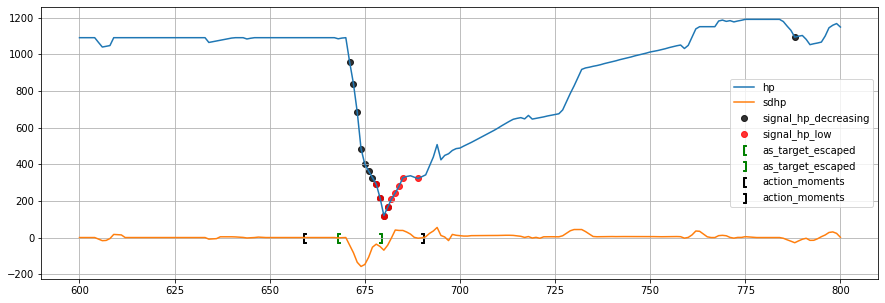

In [90]:
zoom_start, zoom_end = 600, 800
fig, ax = plt.subplots(figsize=(15, 5))
plot_player_signals(
    player,
    ax=ax,
    zoom_start=zoom_start,
    zoom_end=zoom_end,
    # use_minutes=True,
    hp=True,
    # max_hp=True,
    # dhp=True,
    sdhp=True,
    signal_hp_decreasing=True,
    signal_hp_low=True,
    # deaths=True,
    # as_target=True,
    as_target_escaped=True,
    # as_attacker=True,
    # as_attacker_kill=True,
    action_moments=True,
)

plt.grid(True)
plt.show()

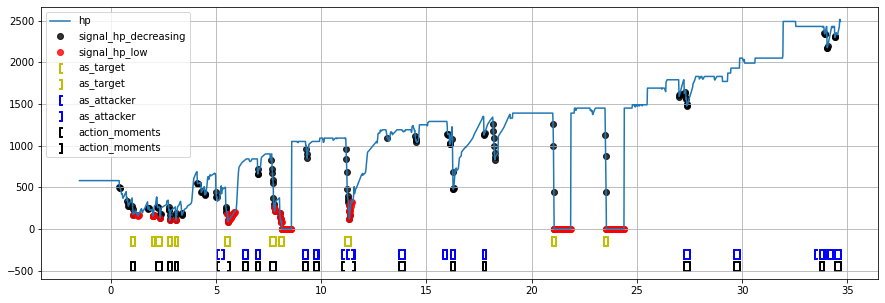

In [117]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_player_signals(
    player,
    ax=ax,
    use_minutes=True,
    hp=True,
    # max_hp=True,
    # dhp=True,
    # sdhp=True,
    signal_hp_decreasing=True,
    signal_hp_low=True,
    # deaths=True,
    as_target=True,
    as_target_line_level=-150,
    # as_target_escaped=True,
    as_attacker=True,
    as_attacker_line_level=-300,
    # as_attacker_kill=True,
    action_moments=True,
    action_moments_line_level=-450,
)

plt.grid(True)
plt.show()

Problems:
- The laning phase is usually boring
- What moments are interesting?

Hueristics:
- 1x1
- Mass Fights
- Skip Laning Phase
- Calculate Damage
- Check for epic abilities: Black Hole, Reverse Polarity
...

## YouTube

In [170]:
url = 'https://www.youtube.com/watch?v=XTngObUROMo&ab_channel=DotADigest'

In [180]:
analyze_video(
    url=url,
    keep_video=True,
    keep_frames=True,
    force_process=True,
    frames_limit=30,
    min_confidence=0,
)

2022-10-12 16:38:31.870 | DEBUG    | youtube:analyze_video:297 - url='https://www.youtube.com/watch?v=XTngObUROMo&ab_channel=DotADigest', min_confidence=0, keep_video=True, keep_frames=True, force_process=True, frames_limit=30
2022-10-12 16:38:31.870 | DEBUG    | utils:query_opendota:33 - 
    SELECT
        match_id,
        start_time,
        matches.leagueid,
        leagues.name as league,
        radiant_team_id,
        radiant_team.name as radiant_name,
        radiant_team.tag as radiant_tag,
        dire_team_id,
        dire_team.name as dire_name,
        dire_team.tag as dire_tag
    FROM
        matches
        join teams as dire_team on matches.dire_team_id = dire_team.team_id
        join teams as radiant_team on matches.radiant_team_id = radiant_team.team_id
        join leagues on matches.leagueid = leagues.leagueid
    WHERE
        start_time >= extract(epoch from timestamp '07-22-2022')
        and start_time < extract(epoch from timestamp '07-25-2022')
    ORDER B

In [174]:
os.listdir(FRAMES_DIR)[:10]

['XTngObUROMo__1243.bmp',
 'XTngObUROMo__539.bmp',
 'XTngObUROMo__1257.bmp',
 'XTngObUROMo__277.bmp',
 'XTngObUROMo__511.bmp',
 'XTngObUROMo__505.bmp',
 'XTngObUROMo__263.bmp',
 'XTngObUROMo__288.bmp',
 'XTngObUROMo__1280.bmp',
 'XTngObUROMo__1294.bmp']

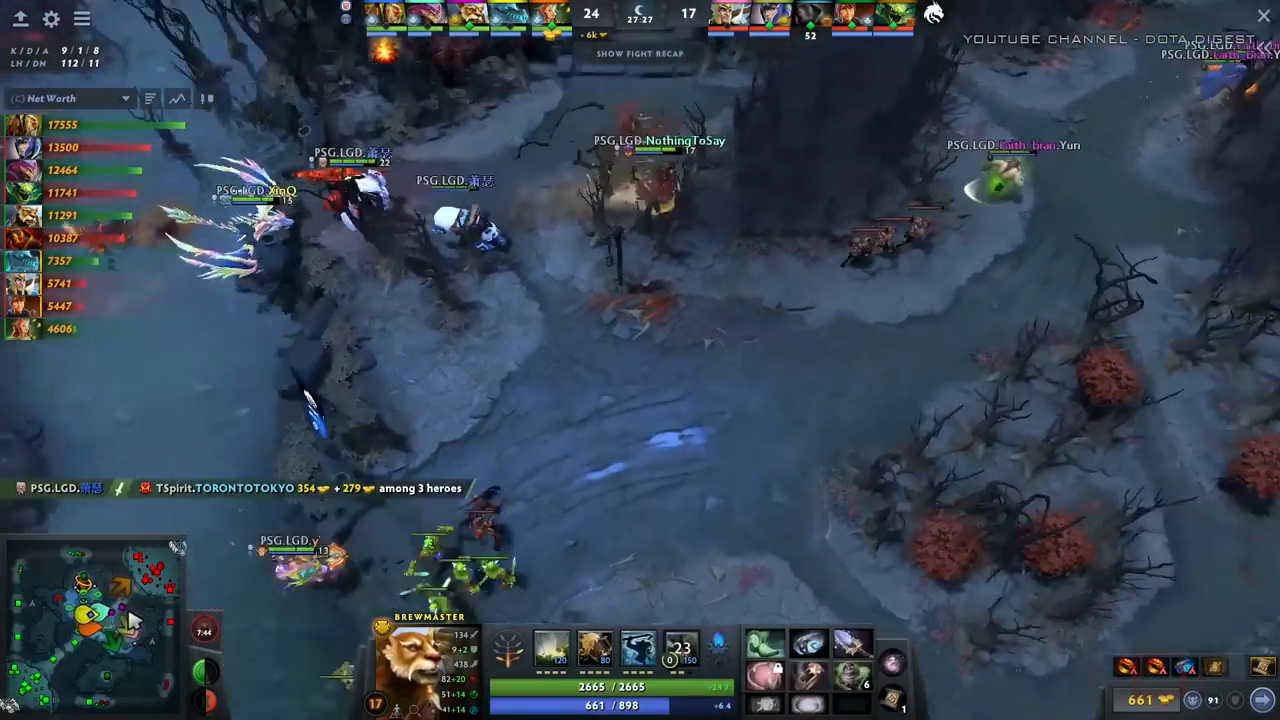

In [175]:
frame_path = FRAMES_DIR / 'XTngObUROMo__539.bmp'
Image.open(frame_path)

In [176]:
crop = crop_frame(frame_path)
crop[:1]

array([[[41, 51, 58],
        [41, 51, 58],
        [41, 51, 58],
        ...,
        [77, 91, 99],
        [77, 91, 99],
        [77, 91, 99]]], dtype=uint8)

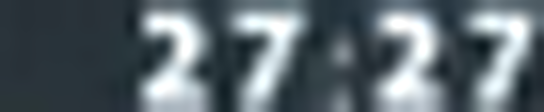

In [177]:
Image.fromarray(crop)

In [178]:
frame_text = extract_text(crop)
frame_text

'27.27'

In [179]:
convert_to_timestamp(frame_text)

1647

In [149]:
video_id, metadata = get_video_metadata(url)
title = metadata['fulltitle']
upload_date = datetime.strptime(metadata['upload_date'], '%Y%m%d')
print(title, '\n')
print(upload_date)

TEAM SPIRIT vs PSG LGD - $1,500,000 GRAND FINAL - RIYADH MASTERS 2022 Dota 2 Highlights 

2022-07-24 00:00:00


In [166]:
matches = get_nearest_matches(upload_date)
print(len(matches))
matches[120]

2022-10-12 16:32:06.215 | DEBUG    | utils:query_opendota:33 - 
    SELECT
        match_id,
        start_time,
        matches.leagueid,
        leagues.name as league,
        radiant_team_id,
        radiant_team.name as radiant_name,
        radiant_team.tag as radiant_tag,
        dire_team_id,
        dire_team.name as dire_name,
        dire_team.tag as dire_tag
    FROM
        matches
        join teams as dire_team on matches.dire_team_id = dire_team.team_id
        join teams as radiant_team on matches.radiant_team_id = radiant_team.team_id
        join leagues on matches.leagueid = leagues.leagueid
    WHERE
        start_time >= extract(epoch from timestamp '07-22-2022')
        and start_time < extract(epoch from timestamp '07-25-2022')
    ORDER BY
        start_time desc
    LIMIT
        500
    


288


{'match_id': 6674674272,
 'start_time': 1658595263,
 'leagueid': 14389,
 'league': 'ESL One Malaysia 2022 Qualifiers powered by Intel',
 'radiant_team_id': 8751213,
 'radiant_name': 'sQreens squad',
 'radiant_tag': 'ss',
 'dire_team_id': 8545488,
 'dire_name': 'cybercats',
 'dire_tag': 'CyberC'}

In [163]:
team_pairs = generate_team_pairs(matches)
list(team_pairs.items())[7:15]

[('alpha vs KBU.US', 6676612110),
 ('Ravens vs Hokori', 6676495794),
 ('Hokori vs Ravens', 6676495794),
 ('Team Spirit vs PSG.LGD', 6676393091),
 ('PSG.LGD vs Team Spirit', 6676393091),
 ('TSpirit vs PSG.LGD', 6676393091),
 ('PSG.LGD vs TSpirit', 6676393091),
 ('5ManMidas vs Samba Team', 6676355860)]

In [168]:
search_team_pairs('TEAM SPIRIT vs PSG LGD', matches)

6676393091

## IoU

In [189]:
df_youtube = pd.read_csv(YOUTUBE_DIR / 'XTngObUROMo.csv')
df_youtube.columns = ['video_id', 'cluster', 'clock_start', 'clock_end', 'start', 'end']
df_youtube['time'] = df_youtube['start'] 
df_youtube = TimeTable(df_youtube)
df_youtube

,video_id,cluster,clock_start,clock_end,start,end,time
0,XTngObUROMo,0,00:19,00:02,19,2,19
1,XTngObUROMo,1,01:00,01:19,60,79,60
2,XTngObUROMo,2,02:38,03:14,158,194,158
3,XTngObUROMo,3,04:30,05:35,270,335,270
4,XTngObUROMo,4,14:19,14:56,859,896,859
5,XTngObUROMo,5,15:53,16:13,953,973,953
6,XTngObUROMo,6,18:06,18:13,1086,1093,1086
7,XTngObUROMo,7,18:47,18:56,1127,1136,1127
8,XTngObUROMo,8,21:11,21:47,1271,1307,1271
9,XTngObUROMo,9,22:34,24:25,1354,1465,1354


In [196]:
df_youtube.dtypes

video_id       object
cluster         int64
clock_start    object
clock_end      object
start           int64
end             int64
time            int64
dtype: object

In [199]:
df_youtube.t(0, 1500)

,video_id,cluster,clock_start,clock_end,start,end,time
0,XTngObUROMo,0,00:19,00:02,19,2,19
1,XTngObUROMo,1,01:00,01:19,60,79,60
2,XTngObUROMo,2,02:38,03:14,158,194,158
3,XTngObUROMo,3,04:30,05:35,270,335,270
4,XTngObUROMo,4,14:19,14:56,859,896,859
5,XTngObUROMo,5,15:53,16:13,953,973,953
6,XTngObUROMo,6,18:06,18:13,1086,1093,1086
7,XTngObUROMo,7,18:47,18:56,1127,1136,1127
8,XTngObUROMo,8,21:11,21:47,1271,1307,1271
9,XTngObUROMo,9,22:34,24:25,1354,1465,1354


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/dsavostianov/proj/woodota/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kf/0g1tcd4552s63cr0z3p7rync9r1w79/T/ipykernel_35777/1796349833.py", line 2, in <cell line: 2>
    plot_player_signals(
  File "/Users/dsavostianov/proj/woodota/notebooks/../src/utils.py", line 387, in plot_player_signals
    if df_youtube:
  File "/Users/dsavostianov/proj/woodota/env/lib/python3.10/site-packages/pandas/core/generic.py", line 1527, in __nonzero__
    raise ValueError(
ValueError: The truth value of a TimeTable is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/dsavostianov/proj/woodota/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.Inte

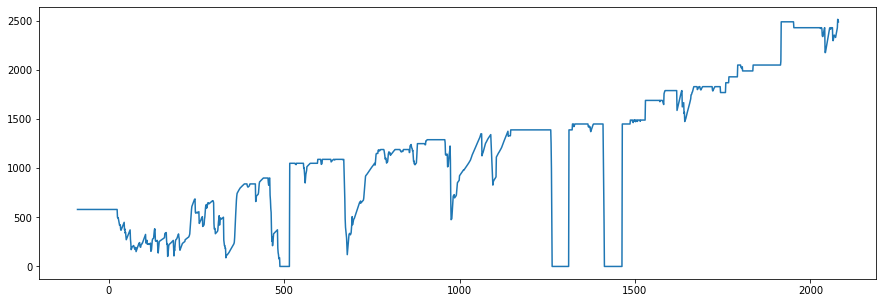

In [194]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_player_signals(
    player,
    df_youtube,
    ax=ax,
    # use_minutes=True,
    hp=True,
    # # max_hp=True,
    # # dhp=True,
    # # sdhp=True,
    # signal_hp_decreasing=True,
    # signal_hp_low=True,
    # # deaths=True,
    # as_target=True,
    # as_target_line_level=-150,
    # # as_target_escaped=True,
    # as_attacker=True,
    # as_attacker_line_level=-300,
    # # as_attacker_kill=True,
    # action_moments=True,
    # action_moments_line_level=-450,
)

plt.grid(True)
plt.show()

In [ ]:
calculate_iou

In [206]:
youtube_moments = (
    df_youtube[['start', 'end']]
    .to_dict('records')
)
youtube_moments

[{'start': 19, 'end': 2},
 {'start': 60, 'end': 79},
 {'start': 158, 'end': 194},
 {'start': 270, 'end': 335},
 {'start': 859, 'end': 896},
 {'start': 953, 'end': 973},
 {'start': 1086, 'end': 1093},
 {'start': 1127, 'end': 1136},
 {'start': 1271, 'end': 1307},
 {'start': 1354, 'end': 1465},
 {'start': 1552, 'end': 1596},
 {'start': 1646, 'end': 1679},
 {'start': 1692, 'end': 1824}]

In [207]:
match_moments = match.action_moments[['start', 'end']].to_dict('records')

In [208]:
calculate_iou(match_moments, youtube_moments)

0.18834080717488788